## Import 

In [173]:
import os
import heapq
import joblib
import random
import numpy as np
import pandas as pd
import seaborn as sns 
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Dataset

In [174]:
df = pd.read_csv("social_media_vs_productivity.csv")
df.head().T

,0,1,2,3,4
age,56,46,32,60,25
gender,Male,Male,Male,Female,Male
job_type,Unemployed,Health,Finance,Unemployed,IT
daily_social_media_time,4.18094,3.249603,NaN,NaN,NaN
social_platform_preference,Facebook,Twitter,Twitter,Facebook,Telegram
number_of_notifications,61,59,57,59,66
work_hours_per_day,6.753558,9.169296,7.910952,6.355027,6.214096
perceived_productivity_score,8.040464,5.063368,3.861762,2.916331,8.868753
actual_productivity_score,7.291555,5.165093,3.474053,1.774869,NaN
stress_level,4.0,7.0,4.0,6.0,7.0


## Column Types

In [175]:
# feature & target
all_features = ['age', 'gender', 'job_type', 'daily_social_media_time',
       'social_platform_preference', 'number_of_notifications',
       'work_hours_per_day', 'perceived_productivity_score', 'stress_level',
       'sleep_hours', 'screen_time_before_sleep', 'breaks_during_work',
       'uses_focus_apps', 'has_digital_wellbeing_enabled',
       'coffee_consumption_per_day', 'days_feeling_burnout_per_month',
       'weekly_offline_hours', 'job_satisfaction_score']
target = 'actual_productivity_score'

In [176]:
# remove missing Y
initial_rows = df.shape[0]
print(f"Original DataFrame rows: {initial_rows}")
print(f"NaNs in target '{target}' BEFORE dropping: {df[target].isnull().sum()}")

df.dropna(subset=[target], inplace=True)

rows_after_target_nan_drop = df.shape[0]
print(f"Dropped {initial_rows - rows_after_target_nan_drop} rows with missing '{target}' values.")
print(f"DataFrame rows after target NaN drop: {rows_after_target_nan_drop}")
print(f"NaNs in target '{target}' AFTER dropping: {df[target].isnull().sum()}")


Original DataFrame rows: 30000
NaNs in target 'actual_productivity_score' BEFORE dropping: 2365
Dropped 2365 rows with missing 'actual_productivity_score' values.
DataFrame rows after target NaN drop: 27635
NaNs in target 'actual_productivity_score' AFTER dropping: 0


In [177]:
# outlier
print("\n--- Performing Outlier Removal (IQR Method) ---")
numerical_cols_for_outliers = df[all_features].select_dtypes(include=np.number).columns.tolist()
if target not in numerical_cols_for_outliers:
    numerical_cols_for_outliers.append(target)

df_before_outlier_removal = df.shape[0]
print(f"Rows before outlier removal: {df_before_outlier_removal}")

for col in numerical_cols_for_outliers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound) | df[col].isna()]
    print(f"  - Applied IQR to '{col}'. Rows remaining: {df.shape[0]}")

rows_after_outlier_removal = df.shape[0]
removed_rows = df_before_outlier_removal - rows_after_outlier_removal
print(f"Total rows removed due to outliers: {removed_rows}")
print(f"DataFrame rows after outlier removal: {rows_after_outlier_removal}")


--- Performing Outlier Removal (IQR Method) ---
Rows before outlier removal: 27635
  - Applied IQR to 'age'. Rows remaining: 27635
  - Applied IQR to 'daily_social_media_time'. Rows remaining: 27439
  - Applied IQR to 'number_of_notifications'. Rows remaining: 27197
  - Applied IQR to 'work_hours_per_day'. Rows remaining: 27109
  - Applied IQR to 'perceived_productivity_score'. Rows remaining: 27109
  - Applied IQR to 'stress_level'. Rows remaining: 27109
  - Applied IQR to 'sleep_hours'. Rows remaining: 27109
  - Applied IQR to 'screen_time_before_sleep'. Rows remaining: 27020
  - Applied IQR to 'breaks_during_work'. Rows remaining: 27020
  - Applied IQR to 'coffee_consumption_per_day'. Rows remaining: 26905
  - Applied IQR to 'days_feeling_burnout_per_month'. Rows remaining: 26905
  - Applied IQR to 'weekly_offline_hours'. Rows remaining: 26799
  - Applied IQR to 'job_satisfaction_score'. Rows remaining: 26799
  - Applied IQR to 'actual_productivity_score'. Rows remaining: 26799
Tot

In [178]:
# X & Y
X = df[all_features].copy()
y = df[target]

In [179]:
# numeric & catgorical
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

## Missing Value

In [180]:
# check missing X
print("\n--- Initial Missing Values Across All Columns ---")
missing_info = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_info, 'Missing %': missing_percentage})
print(missing_df.sort_values(by='Missing %', ascending=False))
print("-" * 50) 


--- Initial Missing Values Across All Columns ---
                                Missing Count  Missing %
daily_social_media_time                  2490   9.291391
job_satisfaction_score                   2434   9.082428
sleep_hours                              2334   8.709280
screen_time_before_sleep                 1990   7.425650
stress_level                             1717   6.406955
perceived_productivity_score             1446   5.395724
number_of_notifications                     0   0.000000
work_hours_per_day                          0   0.000000
actual_productivity_score                   0   0.000000
gender                                      0   0.000000
social_platform_preference                  0   0.000000
job_type                                    0   0.000000
breaks_during_work                          0   0.000000
uses_focus_apps                             0   0.000000
has_digital_wellbeing_enabled               0   0.000000
coffee_consumption_per_day           

## Tran-Test Split

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTrain set shape: {X_train.shape}, Test set shape: {X_test.shape}")


Train set shape: (21439, 18), Test set shape: (5360, 18)


## Pre-Processing Pipelines

In [182]:
# numeric (imputer, scaler)
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# categorical (imputer, encoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

In [183]:
# fit & transform
print("Fitting and transforming data with preprocessor...")
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
print(f"X_train_transformed shape: {X_train_transformed.shape}")

Fitting and transforming data with preprocessor...
X_train_transformed shape: (21439, 29)


In [184]:
# preview result
feature_names_out = preprocessor.get_feature_names_out()
if hasattr(X_train_transformed, 'toarray'):
    X_transformed_dense = X_train_transformed.toarray()
else:
    X_transformed_dense = X_train_transformed
X_transformed_df = pd.DataFrame(X_transformed_dense, columns=feature_names_out)

print(f"\nShape of Transformed X DataFrame: {X_transformed_df.shape}")
print("\n--- First 5 rows of Transformed X (as DataFrame) ---")
X_transformed_df.head().T


Shape of Transformed X DataFrame: (21439, 29)

--- First 5 rows of Transformed X (as DataFrame) ---


,0,1,2,3,4
num__age,0.763962,-0.971418,-1.477570,-0.899110,-0.031420
num__daily_social_media_time,-0.025607,0.359916,-1.689747,2.622637,-0.195212
num__number_of_notifications,1.769623,0.962174,1.635048,-0.383575,-0.787300
num__work_hours_per_day,-0.137377,0.694431,0.380403,0.080813,0.892239
num__perceived_productivity_score,1.002713,0.044908,1.200149,-1.512239,0.955395
num__stress_level,0.170423,0.456786,-1.261390,-0.903437,0.886330
num__sleep_hours,-1.406200,0.808483,-0.962044,0.543425,-0.081787
num__screen_time_before_sleep,0.066732,-1.352777,0.108706,-0.643638,-1.630811
num__breaks_during_work,-0.627142,-0.942404,0.633906,-0.627142,0.318644
num__coffee_consumption_per_day,-0.714579,0.014591,-0.714579,-1.443750,-0.714579


In [185]:
# export proprocessor
PREPROCESSOR_PATH = "model_preprocessor.pkl"
joblib.dump(preprocessor, PREPROCESSOR_PATH)
print(f"Preprocessor saved to: {PREPROCESSOR_PATH}")

Preprocessor saved to: model_preprocessor.pkl


## Modeling

In [186]:
# fit
print("Training XGBoost Regressor model...")
model = xgb.XGBRegressor(
    objective='reg:squarederror', # For regression tasks
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage to prevent overfitting
    random_state=42,
    n_jobs=-1                     # Use all available CPU cores
)
model.fit(X_train_transformed, y_train)
print("XGBoost Regressor model training complete.")

Training XGBoost Regressor model...
XGBoost Regressor model training complete.


In [187]:
# eval
y_pred = model.predict(X_test_transformed)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [188]:
print(f"Model Performance:")
print(f"  Mean Squared Error (MSE): {mse:.4f}")
print(f"  R2 Score: {r2:.4f}")

Model Performance:
  Mean Squared Error (MSE): 0.2958
  R2 Score: 0.9169


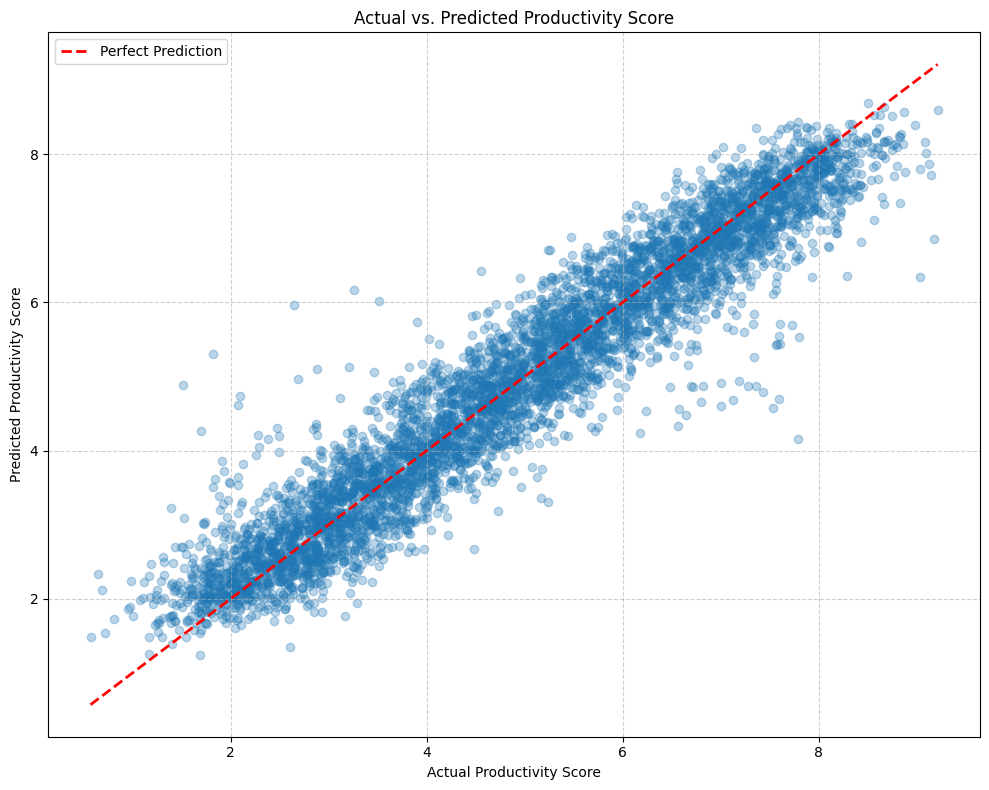

In [189]:
# visualize
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.title('Actual vs. Predicted Productivity Score')
plt.xlabel('Actual Productivity Score')
plt.ylabel('Predicted Productivity Score')
plt.grid(True, linestyle='--', alpha=0.6)

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.legend()
plt.tight_layout()
plt.show()